In [ ]:
import torch
import random
import numpy as np
from numpy.ma.core import outer
from sys import stderr
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib.pyplot import scatter, figure
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd
import seaborn as sns
sns.set(rc={'figure.figsize':(4, 4)})

import warnings

warnings.filterwarnings('ignore')


batch_size = 100

class Experiment(nn.Module):
    def __init__(self):
        super(Experiment, self).__init__()

        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
        print(self.device)

        self.optimizer = None
        self.train_loss_history = []
        self.w_ic = 1.5
        self.w_int = 1
        self.w_data = 1
        self.w_bc = 1.5
        self.w_param_std = 1.0
        self.numInputs = 2
        self.numParams = 2
        self.numOutputs = 1
        self.hidden_size = 25

        # Initialize history variables
        self.total_loss_history = []
        self.loss_ic_history = []
        self.loss_interior_history = []
        self.loss_data_history = []
        self.loss_bc_history = []
        self.loss_std_history = []

        self.t0 = torch.tensor([0.0], requires_grad=True).to(self.device)
        self.y0 = torch.tensor([1.0], requires_grad=True).to(self.device)

        # self.predicted_params = torch.zeros((self.numParams,1), requires_grad=True, device=self.device)
        self.predicted_params = torch.zeros((batch_size,2), requires_grad=True, device=self.device)

        # We only have 1 input feature
        self.b1 = nn.Linear(self.numInputs, self.hidden_size).to(self.device)
        self.b2 = nn.Linear(self.hidden_size, self.hidden_size).to(self.device)
        self.b3 = nn.Linear(self.hidden_size, self.numOutputs).to(self.device)

        self.t1 = nn.Linear(self.hidden_size, self.hidden_size).to(self.device)
        self.t2 = nn.Linear(self.hidden_size, self.hidden_size).to(self.device)
        self.t3 = nn.Linear(self.hidden_size, self.numParams).to(self.device)


    # make this static so that it can be called independently
    @staticmethod
    def exact_solution(t, x):
        return torch.exp(-t) * torch.sin(torch.pi * x)


    def forward(self, t, x):
        if not torch.is_tensor(t):
            t = torch.from_numpy(t).float().to(self.device)

        if not torch.is_tensor(x):
            x = torch.from_numpy(x).float().to(self.device)

        input = torch.cat((t, x), 1)
        h1 = torch.tanh(self.b1(input))
        h2 = torch.tanh(self.b2(h1))

        # prior_param_sample = torch.rand(1, 1, device=self.device).requires_grad_(True)
        prior_param_sample = torch.rand(batch_size, self.hidden_size , device=self.device).requires_grad_(True)

        t1 = torch.tanh(self.t1(prior_param_sample))
        t2 = torch.tanh(self.t2(t1))
        posterior_param_sample = self.t3(t2)
        self.predicted_params = posterior_param_sample

        y = self.b3(torch.multiply(t2, h2))

        return y


    # General formula to compute the n-th order derivative of y = f(x) with respect to x
    def compute_derivative(self, y, x, n):
        if n == 0:
            return y
        else:
            dy_dx = torch.autograd.grad(y, x, torch.ones_like(y, device= self.device),
                                        create_graph=True, retain_graph=True,
                                        allow_unused=True)[0]
        return self.compute_derivative(dy_dx, x, n - 1)



    def PDE_residual(self, t, x):
        y = self.forward(t, x)
        dy_dt = self.compute_derivative(y, t, 1)
        dy_dx = self.compute_derivative(y, x, 1)
        d2y_dx2 = self.compute_derivative(y, x, 2)

        residual =  dy_dt - torch.multiply(self.predicted_params[:,[0]], d2y_dx2) \
            + torch.exp(- self.predicted_params[:,[1]] * t) * (torch.sin(torch.tensor(np.pi) * x) - torch.tensor(np.pi) ** 2 * torch.sin(torch.tensor(np.pi) * x))
        return residual



    def loss_initial_condition(self, num_samples=100):
        t0 = self.t0 * torch.ones((num_samples, 1), device = self.device)
        x = 2*torch.rand((num_samples, 1), device=self.device).requires_grad_(True)  - 1.0
        y0_pred = self.forward(t0, x)
        y0_true = self.exact_solution(t0, x)
        loss_ic = torch.mean(torch.square(y0_true - y0_pred))
        return loss_ic


    def loss_boundary_condition(self, num_samples=100):
        x_low = -1
        x_high = 1
        xb_low   = x_low * torch.ones((num_samples, 1),  device = self.device)
        xb_high  = x_high * torch.ones((num_samples, 1), device = self.device)

        t = 2*torch.rand((num_samples, 1), device=self.device).requires_grad_(True) - 1.0

        yb_low = self.exact_solution(t, xb_low)
        yb_high = self.exact_solution(t, xb_high)

        yb_pred_low = self.forward(t, xb_low)
        yb_pred_high = self.forward(t, xb_high)

        loss_ic = torch.mean(torch.square(yb_pred_low - yb_low)) \
                + torch.mean(torch.square(yb_pred_high - yb_high))
        return loss_ic


    def compute_losses(self):
        loss_ic = self.loss_initial_condition()
        loss_interior = self.loss_interior()
        loss_data = self.loss_data()
        loss_bc = self.loss_boundary_condition()
        return loss_ic, loss_interior, loss_data, loss_bc


    def loss_data(self, num_samples=100):
        t_data, x_data, y_data = next(iter(train_loader))
        y_pred = self.forward(t_data, x_data)
        loss = torch.mean(torch.square(y_pred - y_data))
        return loss


    def loss_interior(self, num_samples=100):

        interior_t_samples = torch.rand((num_samples, 1),   device=self.device).requires_grad_(True)
        interior_x_samples = 2*torch.rand((num_samples, 1), device=self.device).requires_grad_(True)  - 1.0
        res = self.PDE_residual(interior_t_samples, interior_x_samples)
        loss_residual = torch.mean(torch.square(res))
        return loss_residual


    def sample_parameter_posterior(self, num_samples=100):
        prior_param_samples = torch.rand(num_samples, self.hidden_size, device=self.device).requires_grad_(True)
        t1 = torch.tanh(self.t1(prior_param_samples))
        t2 = torch.tanh(self.t2(t1))
        posterior_param_samples = self.t3(t2)
        return posterior_param_samples



    def update_predicted_params(self, posterior_samples):

        mean = torch.mean(posterior_samples, dim=0)  # Compute the mean along the first axis
        std = torch.std(posterior_samples, dim=0)    # Compute the standard deviation along the first axis

        self.predicted_params = posterior_samples
        self.mean_predicted_params = mean  # Store the mean
        self.std_params = std  # Attach the standard deviation as an attribute


    def closure(self):
        self.optimizer.zero_grad()
        loss_ic, loss_interior, loss_data, loss_bc = self.compute_losses()
        total_loss = self.w_ic * loss_ic \
                   + self.w_int * loss_interior \
                   + self.w_data * loss_data \
                   + self.w_bc * loss_bc

        # Sample the parameter posterior and update self.predicted_params and self.std_params
        posterior_samples = self.sample_parameter_posterior(num_samples=100)
        self.update_predicted_params(posterior_samples)

        # Add the (Log(std))**2 term to the loss with the specified weight
        self.log_std_squared_loss = self.w_param_std * torch.mean(torch.log(self.std_params)**2)
        total_loss += self.log_std_squared_loss

        total_loss.backward(retain_graph=True)
        return total_loss


    def train(self, epochs, optimizer='Adam', num_samples=100, **kwargs):
        if optimizer == 'Adam':
            self.optimizer = torch.optim.Adam(self.parameters(), **kwargs)

        elif optimizer == 'L-BFGS':
            self.optimizer = torch.optim.LBFGS(self.parameters(), **kwargs)

        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(self.optimizer, mode='min', factor=0.1, patience=10, verbose=True)


        # Training loop
        for epoch in range(epochs):
            self.optimizer.step(self.closure)
            if epoch % 1000 == 0:
                loss_ic, loss_interior, loss_data, loss_bc = self.compute_losses()
                total_loss = loss_ic + loss_interior + loss_data + loss_bc

                scheduler.step(total_loss)

                # Append losses to history
                self.total_loss_history.append(total_loss.item())
                self.loss_ic_history.append(loss_ic.item())
                self.loss_interior_history.append(loss_interior.item())
                self.loss_data_history.append(loss_data.item())
                self.loss_bc_history.append(loss_bc.item())
                self.loss_std_history.append(self.log_std_squared_loss.item())

                print(f'Epoch({optimizer}):{epoch},  Total Loss:{total_loss.item():.2f}  ' \
                        f'PDE Loss:{loss_interior.item():.2f}  ' \
                        f'BC Loss:{loss_bc.item():.2f}  ' \
                        f'IC Loss: {loss_ic.item():.2f}  ' \
                        # f'Predicted Param:{self.predicted_params.detach().cpu().numpy()[0][0]:.2f}'
                        f'Mean Predicted Param 1: {self.mean_predicted_params[0]:.2f} ' \
                        f'Mean Predicted Param 2: {self.mean_predicted_params[1]:.2f} ' \
                        f'Std Params:{self.std_params.detach().cpu().numpy()[0]:.2f}  ' \
                        f'Std Log Loss:{self.log_std_squared_loss.item():.2f}')

In [ ]:
def sample_dataset(noise=0.1, numSamples=100, device='cpu'):
    t = torch.linspace(0, 1, numSamples, device=device) # Time domain
    x = torch.linspace(-1, 1, numSamples, device=device) # Space domain

    T, X   = torch.meshgrid(t, x) # Time-Space domain

    y_true = Experiment.exact_solution(T, X)
    T      = T.reshape(-1, 1) # Reshape to 2D to 1D
    X      = X.reshape(-1, 1) # Resahpe to 2D to 1D

    sample_mean = y_true.reshape(-1, 1)
    sample_var  = noise * torch.ones_like(sample_mean)
    Y_noisy     = torch.normal(sample_mean, sample_var)

    return T, X, Y_noisy


def create_train_test_datasets(device='cpu', batch_size = batch_size):
    t_train, x_train, y_train = sample_dataset(noise=0.01, numSamples=10, device=device)
    t_test, x_test, y_test = sample_dataset(noise=0.0, numSamples=100, device=device)

    fig = plt.figure()
    size = int(t_test.size(0)**0.5)


    plt.contourf(t_test.view(size, size).cpu().detach().numpy(),
                 x_test.view(size, size).cpu().detach().numpy(),
                 y_test.view(size, size).cpu().detach().numpy())
    plt.xlabel('t'); plt.ylabel('x');
    plt.colorbar()

    train_dataset = TensorDataset(t_train, x_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    test_dataset = TensorDataset(t_test, x_test, y_test)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

    return train_loader, test_loader


# sending only 10 samples due to mismatch
def plot_residuals(net, device, noise=0.0):
    t_test, x_test, y_test = sample_dataset(noise=noise, numSamples=100, device=device)

    # Define batch size
    batch_size = 100

    # Split the test dataset into batches
    t_batches = torch.split(t_test, batch_size)
    x_batches = torch.split(x_test, batch_size)

    # Initialize lists to store results
    mu_results = []
    t_results = []
    x_results = []

    # Iterate over batches
    for t_batch, x_batch in zip(t_batches, x_batches):
        # Call mu for each batch
        mu_batch = net.forward(t_batch, x_batch)
        mu_results.append(mu_batch)
        t_results.append(t_batch)
        x_results.append(x_batch)

    # Concatenate the results
    mu = torch.cat(mu_results)
    t_final = torch.cat(t_results)
    x_final = torch.cat(x_results)

    fig  = plt.figure(figsize=(6, 3))
    ax1  = plt.subplot(121)
    size = int(np.sqrt(x_test.size(0)))

    # Calculate the residuals (difference between predictions and ground truth)
    absDifference  = torch.abs(mu - y_test)
    residuals      = absDifference.view(size, size).cpu().detach().numpy()

    # Create a contour plot of the residuals
    cax = ax1.contourf(t_final.view(size, size).cpu().detach().numpy(),
                       x_final.view(size, size).cpu().detach().numpy(),
                       residuals)

    plt.colorbar(cax)
    plt.xlabel('t');plt.ylabel('x')
    plt.show()


# sending only 10 samples due to mismatch
def make_plot(net, device):
    t_test, x_test, y_test = sample_dataset(noise=0.0, numSamples=100, device=device)

    # Define batch size
    batch_size = 100

    # Split the test dataset into batches
    t_batches = torch.split(t_test, batch_size)
    x_batches = torch.split(x_test, batch_size)

    # Initialize lists to store results
    mu_results = []
    t_results = []
    x_results = []

    # Iterate over batches
    for t_batch, x_batch in zip(t_batches, x_batches):
        # Call mu for each batch
        mu_batch = net.forward(t_batch, x_batch)
        mu_results.append(mu_batch)
        t_results.append(t_batch)
        x_results.append(x_batch)

    # Concatenate the results
    mu = torch.cat(mu_results)
    t_final = torch.cat(t_results)
    x_final = torch.cat(x_results)

    fig = plt.figure(figsize=(6, 3))
    ax1 = plt.subplot(121)
    ax2 = plt.subplot(122, sharex=ax1)
    size = int(np.sqrt(x_test.size(0)))

    ax1.contourf(t_final.view(size, size).cpu().detach().numpy(),
                 x_final.view(size, size).cpu().detach().numpy(),
                 mu.view(size, size).cpu().detach().numpy())

    plt.xlabel('t')
    plt.ylabel('x')

    ax2.contourf(t_test.view(size, size).cpu().detach().numpy(),
                 x_test.view(size, size).cpu().detach().numpy(),
                 y_test.view(size, size).cpu().detach().numpy())

    plt.show()


def plot_loss_history(net):
    epochs = range(len(net.total_loss_history))

    plt.figure(figsize=(8, 6))
    plt.plot(epochs, net.total_loss_history, label='Total Loss')
    plt.plot(epochs, net.loss_ic_history, label='IC Loss')
    plt.plot(epochs, net.loss_interior_history, label='Interior Loss')
    plt.plot(epochs, net.loss_data_history, label='Data Loss')
    plt.plot(epochs, net.loss_bc_history, label='BC Loss')
    plt.plot(epochs, net.loss_std_history, label='STD Loss')

    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Over Epochs')
    plt.legend()
    plt.show()


def plot_loss_history_log(net):
    epochs = range(len(net.total_loss_history))

    plt.figure(figsize=(8, 6))
    plt.semilogy(epochs, net.total_loss_history, label='Total Loss')
    plt.semilogy(epochs, net.loss_ic_history, label='IC Loss')
    plt.semilogy(epochs, net.loss_interior_history, label='Interior Loss')
    plt.semilogy(epochs, net.loss_data_history, label='Data Loss')
    plt.semilogy(epochs, net.loss_bc_history, label='BC Loss')
    plt.semilogy(epochs, net.loss_std_history, label='STD Loss')

    plt.xlabel('Epochs')
    plt.ylabel('Loss (log scale)')
    plt.title('Loss Over Epochs (log scale)')
    plt.legend()
    plt.show()


In [ ]:
net = Experiment()
net.to(net.device)
print("Params:", sum(p.numel() for p in net.parameters() if p.requires_grad))

cpu
Params: 2103


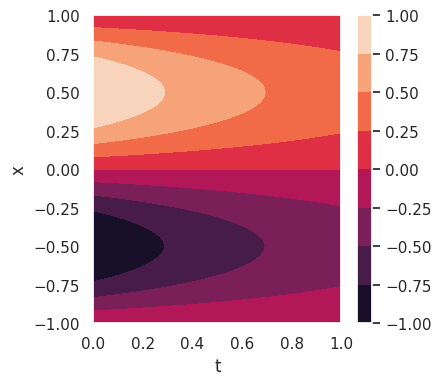

In [ ]:
train_loader, test_loader = create_train_test_datasets(device = net.device, batch_size=batch_size)

In [ ]:
net.w_ic = 2
net.w_data = 5
net.w_bc   = 3
net.w_int = 4
net.w_param_std = 1

In [ ]:
torch.autograd.set_detect_anomaly(True)
net.train(10000, optimizer='Adam', lr=1e-2)

Epoch(Adam):0,  Total Loss:25.32  PDE Loss:24.67  BC Loss:0.01  IC Loss: 0.44  Mean Predicted Param 1: -0.14 Mean Predicted Param 2: 0.15 Std Params:0.06  Std Log Loss:10.18
Epoch(Adam):1000,  Total Loss:0.23  PDE Loss:0.06  BC Loss:0.05  IC Loss: 0.05  Mean Predicted Param 1: 1.57 Mean Predicted Param 2: 4.67 Std Params:0.62  Std Log Loss:0.13
Epoch(Adam):2000,  Total Loss:0.18  PDE Loss:0.09  BC Loss:0.01  IC Loss: 0.03  Mean Predicted Param 1: 1.52 Mean Predicted Param 2: 3.57 Std Params:0.76  Std Log Loss:0.04
Epoch(Adam):3000,  Total Loss:0.32  PDE Loss:0.27  BC Loss:0.01  IC Loss: 0.01  Mean Predicted Param 1: 1.12 Mean Predicted Param 2: 2.02 Std Params:0.57  Std Log Loss:0.22
Epoch(Adam):4000,  Total Loss:0.15  PDE Loss:0.08  BC Loss:0.02  IC Loss: 0.02  Mean Predicted Param 1: 1.20 Mean Predicted Param 2: 1.97 Std Params:0.68  Std Log Loss:0.09
Epoch(Adam):5000,  Total Loss:0.08  PDE Loss:0.04  BC Loss:0.01  IC Loss: 0.02  Mean Predicted Param 1: 1.22 Mean Predicted Param 2: 1

In [ ]:
torch.save({
    'model_state_dict': net.state_dict(),
    'optimizer_state_dict': net.optimizer.state_dict(),
    'total_loss_history': net.total_loss_history,
    'loss_ic_history': net.loss_ic_history,
    'loss_interior_history': net.loss_interior_history,
    'loss_data_history': net.loss_data_history,
    'loss_bc_history': net.loss_bc_history,
    'loss_std_history': net.loss_std_history
    # Add other variables if needed
}, f'model_checkpoint_trained.pth')

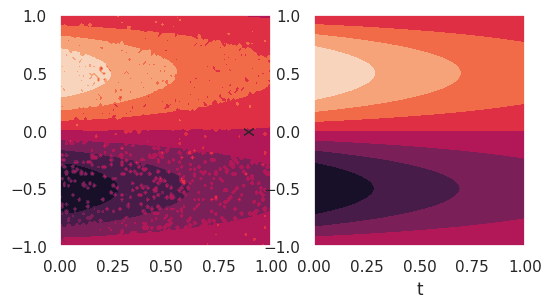

In [ ]:
make_plot(net, device=net.device)

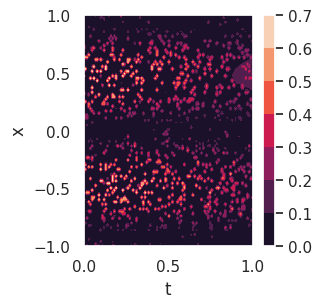

In [ ]:
plot_residuals(net, device=net.device, noise=0.0)

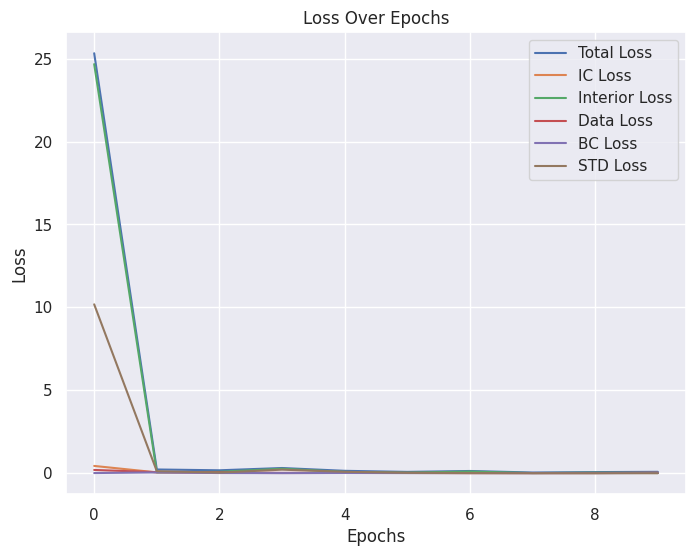

In [ ]:
plot_loss_history(net)

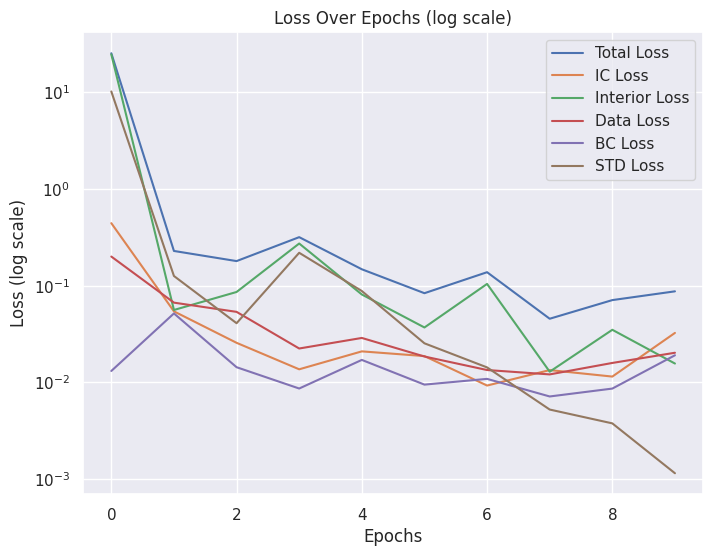

In [ ]:
plot_loss_history_log(net)

In [ ]:
# why are we sampling a new set of posterior here, instead of using predicted posterior params from the last iteration?
samples = net.sample_parameter_posterior(num_samples=100)

In [ ]:
samples.mean(axis=0), samples.std(axis=0)

(tensor([1.3205, 1.6984], grad_fn=<MeanBackward1>),
 tensor([0.9453, 1.0845], grad_fn=<StdBackward0>))

In [ ]:
# why can't we do this?
column_means = torch.mean(net.predicted_params, dim=0)
column_means

tensor([1.2866, 1.6600], grad_fn=<MeanBackward1>)

In [ ]:
p1, p2 = samples.cpu().detach().unbind(1)

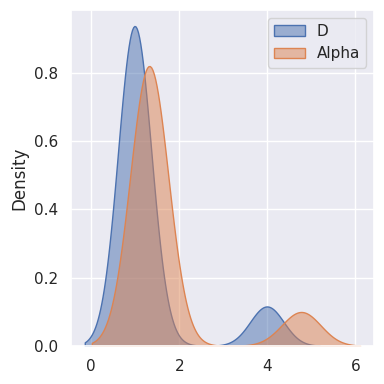

In [ ]:
# Plot KDE plots
g = sns.kdeplot(p1, fill=True, palette="crest", alpha=.5, linewidth=1)
g = sns.kdeplot(p2, fill=True, palette="crest", alpha=.5, linewidth=1)
g.legend(['D', 'Alpha'])

plt.tight_layout()
plt.show()

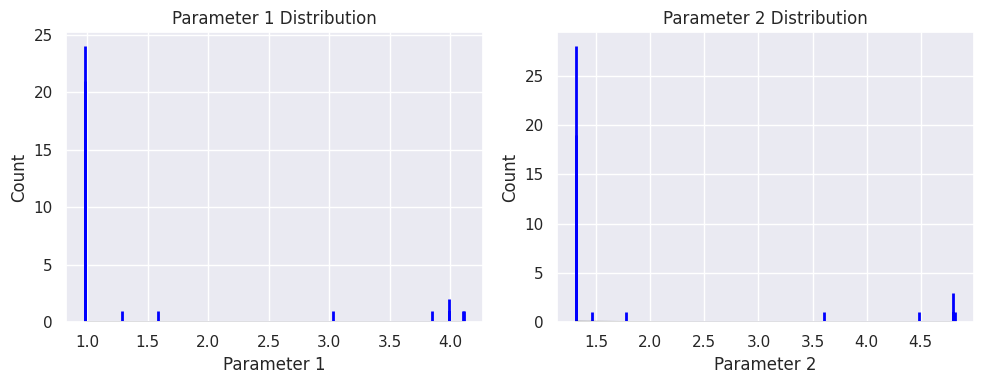

In [ ]:
samples = net.sample_parameter_posterior(num_samples=100).cpu().detach().numpy()

df = pd.DataFrame(samples, columns=['Parameter 1', 'Parameter 2'])

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
sns.histplot(df['Parameter 1'], kde=True, linewidth=2, edgecolor='blue', color='black')
plt.title('Parameter 1 Distribution')

plt.subplot(1, 2, 2)
sns.histplot(df['Parameter 2'], kde=True, linewidth=2, edgecolor='blue', color='black')
plt.title('Parameter 2 Distribution')

plt.tight_layout()
plt.show()

**Testing the bayesian approach with sample data**

In [ ]:
def create_posterior_test_data(net):
  t_test, x_test, y_test = sample_dataset(noise=0.0, numSamples=10, device=net.device)

  num1 = random.randint(0, 98)
  num2 = num1 + 1

  t_test[:] = t_test[num1:num2]
  x_test[:] = x_test[num1:num2]
  y_test[:] = y_test[num1:num2]

  return t_test, x_test

In [ ]:
def forward_posterior(net, t, x):
    if not torch.is_tensor(t):
        t = torch.from_numpy(t).float().to(net.device)

    if not torch.is_tensor(x):
        x = torch.from_numpy(x).float().to(net.device)

    input = torch.cat((t, x), 1)
    h1 = torch.tanh(net.b1(input))
    h2 = torch.tanh(net.b2(h1))

    prior_param_sample = torch.rand(1, 1, device=net.device).requires_grad_(True)
    prior_param_sample = prior_param_sample.repeat(100, 25)
    # prior_param_sample = torch.rand(100, 25 , device=net.device).requires_grad_(True)


    t1 = torch.tanh(net.t1(prior_param_sample))
    t2 = torch.tanh(net.t2(t1))
    posterior_param_sample = net.t3(t2)
    net.predicted_params = posterior_param_sample

    y = net.b3(torch.multiply(t2, h2))

    return y

In [ ]:
def calculate_residual(net, t, x):
  y = forward_posterior(net, t, x)
  dy_dt = net.compute_derivative(y, t, 1)
  dy_dx = net.compute_derivative(y, x, 1)
  d2y_dx2 = net.compute_derivative(y, x, 2)

  mean = torch.mean(net.predicted_params, dim=0)
  mode = torch.tensor(np.apply_along_axis(lambda x: np.bincount(x.astype(int)).argmax(), axis=0, arr=net.predicted_params.detach().cpu().numpy()))
  maximum = torch.max(net.predicted_params, dim=0)[0]
  minimum = torch.min(net.predicted_params, dim=0)[0]

  # Update the tensor with the mean value for each column
  for i in range(net.predicted_params.shape[1]):
    net.predicted_params[:, i] = mean[i]

  residual =  dy_dt - torch.multiply(net.predicted_params[:,[0]], d2y_dx2) \
      + torch.exp(- net.predicted_params[:,[1]] * t) * (torch.sin(torch.tensor(np.pi) * x) - torch.tensor(np.pi) ** 2 * torch.sin(torch.tensor(np.pi) * x))

  return residual

In [ ]:
t_test, x_test = create_posterior_test_data(net)

In [ ]:
t_test.requires_grad_(True)
x_test.requires_grad_(True)

residual = calculate_residual(net, t_test, x_test)

In [ ]:
residual

tensor([[0.1452],
        [0.1452],
        [0.1452],
        [0.1452],
        [0.1452],
        [0.1452],
        [0.1452],
        [0.1452],
        [0.1452],
        [0.1452],
        [0.1452],
        [0.1452],
        [0.1452],
        [0.1452],
        [0.1452],
        [0.1452],
        [0.1452],
        [0.1452],
        [0.1452],
        [0.1452],
        [0.1452],
        [0.1452],
        [0.1452],
        [0.1452],
        [0.1452],
        [0.1452],
        [0.1452],
        [0.1452],
        [0.1452],
        [0.1452],
        [0.1452],
        [0.1452],
        [0.1452],
        [0.1452],
        [0.1452],
        [0.1452],
        [0.1452],
        [0.1452],
        [0.1452],
        [0.1452],
        [0.1452],
        [0.1452],
        [0.1452],
        [0.1452],
        [0.1452],
        [0.1452],
        [0.1452],
        [0.1452],
        [0.1452],
        [0.1452],
        [0.1452],
        [0.1452],
        [0.1452],
        [0.1452],
        [0.1452],
        [0

In [ ]:
x = torch.linspace(-1, 1, 100).reshape(-1, 1)
t = torch.linspace(0, 1, 100).reshape(-1, 1)

X, T = torch.meshgrid(x[:, 0], t[:, 0])

y_true = Experiment.exact_solution(T, X)

#### Loading the saved model from the checkpoint
We can load the state of model from the saved checkpoint like shown below and also other necessary states like optimizer state, losses etc.

In [ ]:
checkpoint = torch.load('model_checkpoint_trained.pth')

model = Experiment()  # Create an instance of your Experiment class
model.load_state_dict(checkpoint['model_state_dict'])
model.total_loss_history = checkpoint['total_loss_history']
model.loss_ic_history = checkpoint['loss_ic_history']
model.loss_interior_history = checkpoint['loss_interior_history']
model.loss_data_history = checkpoint['loss_data_history']
model.loss_bc_history = checkpoint['loss_bc_history']
model.loss_std_history = checkpoint['loss_std_history']
model.eval()  # Set the model to evaluation mode

# Load Optimizer's state if necessary
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

device = torch.device("cuda:0" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
model.to(device)

cuda:0


Experiment(
  (b1): Linear(in_features=2, out_features=25, bias=True)
  (b2): Linear(in_features=25, out_features=25, bias=True)
  (b3): Linear(in_features=25, out_features=1, bias=True)
  (t1): Linear(in_features=25, out_features=25, bias=True)
  (t2): Linear(in_features=25, out_features=25, bias=True)
  (t3): Linear(in_features=25, out_features=2, bias=True)
)

#### Once we load the model, we can call the plot functions by passing the new model

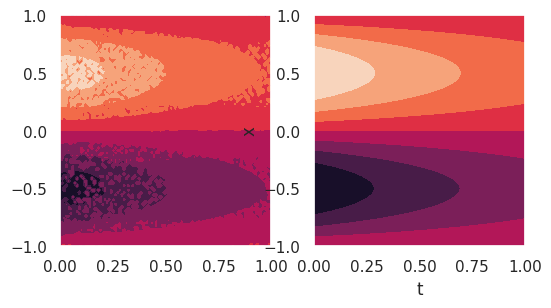

In [ ]:
make_plot(model, device)  # Call the make_plot method to plot the graph

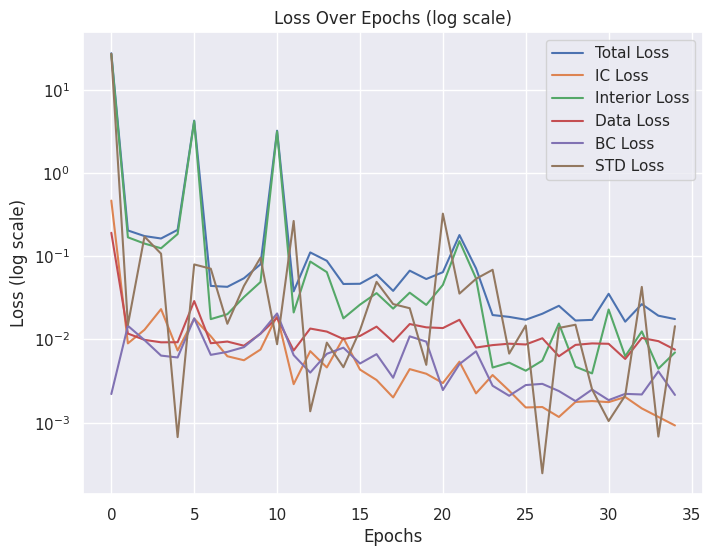

In [ ]:
plot_loss_history_log(model)